In [1]:
# ! pip install pydot
# ! pip install graphviz

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, InputLayer
from keras.optimizers import Adam
import tensorflow as tf

2024-02-28 22:01:13.842671: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 22:01:13.844717: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 22:01:13.871502: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 22:01:13.871532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 22:01:13.872367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
def readFile(path):
    try:
        with open(path, 'r') as file:
            # Skip the first line
            first_line_skipped = False

            # Array to store characters
            temp = []

            # Read and append characters to the array
            for line in file:
                if not first_line_skipped:
                    first_line_skipped = True
                    continue  # Skip the first line
                temp.extend(line.strip())

            # Print the length of sequences
            print(len(temp))
    except FileNotFoundError:
        print(f"File not found: {path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return temp

In [4]:
def pad_genome_sequences(sequence, max_length, padding_char='A'):
    if len(sequence) < max_length:
        # Add padding to the end
        padded_sequence = sequence + list(padding_char * (max_length - len(sequence)))
    elif len(sequence) > max_length:
        # Optionally truncate longer sequences
        padded_sequence = sequence[:max_length]
    else:
        padded_sequence = sequence
        
    print(len(padded_sequence))
    return padded_sequence


In [5]:
# One-hot encoding
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'C': [0, 0, 1, 0], 'G': [0, 0, 0, 1]}
    return np.array([encoding[base] for base in sequence])

In [6]:
def encode(sequences):
    var1 = np.array(one_hot_encode(sequences[0]))
    var2 = np.array(one_hot_encode(sequences[1]))
    temp = np.concatenate((var1[np.newaxis, :], var2[np.newaxis, :]), axis=0)
    for i in range(2,len(sequences)):
        var = np.array(one_hot_encode(sequences[i]))
        temp = np.concatenate((temp, var[np.newaxis, :]), axis=0)
    return temp

In [7]:
HCov229E = readFile('./HCov-229E/ncbi_dataset/data/GCA_000853505.1/GCA_000853505.1_ViralProj14913_genomic.fna')
HCovHKU1 = readFile('./HCov-HKU1/ncbi_dataset/data/GCA_000858765.1/GCA_000858765.1_ViralProj15139_genomic.fna')
HCovNL63 = readFile('./HCov-NL63/ncbi_dataset/data/GCA_000853865.1/GCA_000853865.1_ViralProj14960_genomic.fna')
MERSCoV = readFile('./MERS-CoV/ncbi_dataset/data/GCA_000901155.1/GCA_000901155.1_ViralProj183710_genomic.fna')
SARSCoV = readFile('./SARS-CoV/ncbi_dataset/data/GCA_000864885.1/GCA_000864885.1_ViralProj15500_genomic.fna')
SARSCoV2 = readFile('./SARS-CoV-2/ncbi_dataset/data/genomic.fna')
ASM985889v3 = readFile('./ASM985889v3/ncbi_dataset/data/GCA_009858895.3/GCA_009858895.3_ASM985889v3_genomic.fna')
ASM1153778v1 = readFile('./ASM1153778v1/ncbi_dataset/data/GCA_011537785.1/GCA_011537785.1_ASM1153778v1_genomic.fna')
ASM1153762v1 = readFile('./ASM1153762v1/ncbi_dataset/data/GCA_011537625.1/GCA_011537625.1_ASM1153762v1_genomic.fna')
ASM1153782v2 = readFile('./ASM1153782v2/ncbi_dataset/data/GCA_011537825.2/GCA_011537825.2_ASM1153782v2_genomic.fna')
ASM1154533v2 = readFile('./ASM1154533v2/ncbi_dataset/data/GCA_011545335.2/GCA_011545335.2_ASM1154533v2_genomic.fna')

27317
29926
27553
30119
29751
29903
29903
29854
29876
29882
29882


In [8]:
all_sequences = [SARSCoV, SARSCoV2, MERSCoV, HCov229E, HCovHKU1, HCovNL63, ASM985889v3, ASM1153778v1, ASM1153762v1, ASM1153782v2, ASM1154533v2]

In [9]:
max_length = max(len(seq) for seq in all_sequences)
min_length = min(len(seq) for seq in all_sequences)
length = min_length
SARSCoV = pad_genome_sequences(SARSCoV, length)
SARSCoV2 = pad_genome_sequences(SARSCoV2, length)
MERSCoV = pad_genome_sequences(MERSCoV, length)
HCov229E = pad_genome_sequences(HCov229E, length)
HCovHKU1 = pad_genome_sequences(HCovHKU1, length)
HCovNL63 = pad_genome_sequences(HCovNL63, length)
ASM985889v3 = pad_genome_sequences(ASM985889v3, length)
ASM1153778v1 = pad_genome_sequences(ASM1153778v1,length)
ASM1153762v1 = pad_genome_sequences(ASM1153762v1,length)
ASM1153782v2 = pad_genome_sequences(ASM1153782v2, length)
ASM1154533v2 = pad_genome_sequences(ASM1154533v2,length)

27317
27317
27317
27317
27317
27317
27317
27317
27317
27317
27317


In [10]:
original_sequences = [HCov229E,HCovNL63,SARSCoV,HCovHKU1, MERSCoV, SARSCoV2, ASM985889v3, ASM1153778v1, ASM1153762v1, ASM1153782v2]
mutated_sequences = [HCovNL63,SARSCoV,HCovHKU1,MERSCoV, SARSCoV2, ASM985889v3, ASM1153778v1, ASM1153762v1, ASM1153782v2, ASM1154533v2]

In [11]:
# Convert sequences to categorical for training
X_original = encode(original_sequences)
y_original = encode(mutated_sequences)

In [12]:
# Train-test split
split_index = int(len(X_original) * 0.75)
X_train_original, X_test_original = X_original[:split_index], X_original[split_index:]
y_train_original, y_test_original = y_original[:split_index], y_original[split_index:]

In [13]:
X_train_original.shape

(7, 27317, 4)

In [14]:
# Build the Many-to-Many LSTM model
# Create a Sequential model
model = Sequential()

# Add layers to the model
model.add(InputLayer(input_shape=(27317, 4)))
model.add(LSTM(units=50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(units=4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 27317, 50)         11000     
                                                                 
 dropout (Dropout)           (None, 27317, 50)         0         
                                                                 
 dense (Dense)               (None, 27317, 64)         3264      
                                                                 
 dropout_1 (Dropout)         (None, 27317, 64)         0         
                                                                 
 dense_1 (Dense)             (None, 27317, 32)         2080      
                                                                 
 dropout_2 (Dropout)         (None, 27317, 32)         0         
                                                                 
 dense_2 (Dense)             (None, 27317, 4)          1

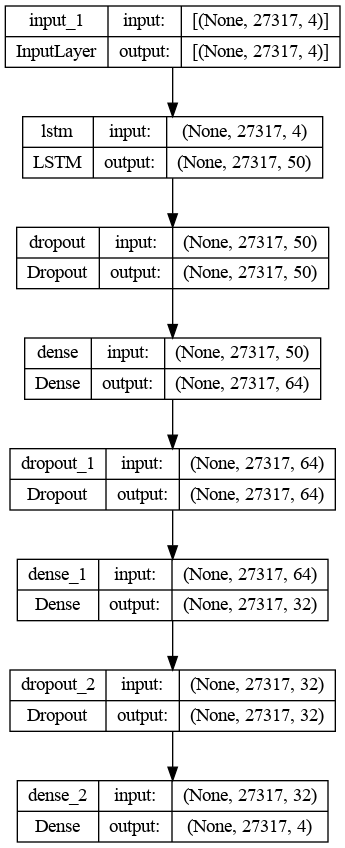

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file="model.png")

In [17]:
# Train the model
history = model.fit(X_train_original, y_train_original, epochs=10, batch_size=5, validation_data=(X_test_original, y_test_original))

Epoch 1/10
2/2 [==============================] - 12s 6s/step - loss: 1.7486 - accuracy: 0.1765 - val_loss: 1.6310 - val_accuracy: 0.1804
Epoch 2/10
2/2 [==============================] - 11s 6s/step - loss: 1.6748 - accuracy: 0.1809 - val_loss: 1.5662 - val_accuracy: 0.1804
Epoch 3/10
2/2 [==============================] - 11s 6s/step - loss: 1.6094 - accuracy: 0.1872 - val_loss: 1.5114 - val_accuracy: 0.1804
Epoch 4/10
2/2 [==============================] - 11s 6s/step - loss: 1.5560 - accuracy: 0.1977 - val_loss: 1.4663 - val_accuracy: 0.1804
Epoch 5/10
2/2 [==============================] - 12s 6s/step - loss: 1.5094 - accuracy: 0.2146 - val_loss: 1.4305 - val_accuracy: 0.1804
Epoch 6/10
2/2 [==============================] - 12s 6s/step - loss: 1.4727 - accuracy: 0.2380 - val_loss: 1.4029 - val_accuracy: 0.3258
Epoch 7/10
2/2 [==============================] - 12s 6s/step - loss: 1.4427 - accuracy: 0.2634 - val_loss: 1.3832 - val_accuracy: 0.3258
Epoch 8/10
2/2 [==================

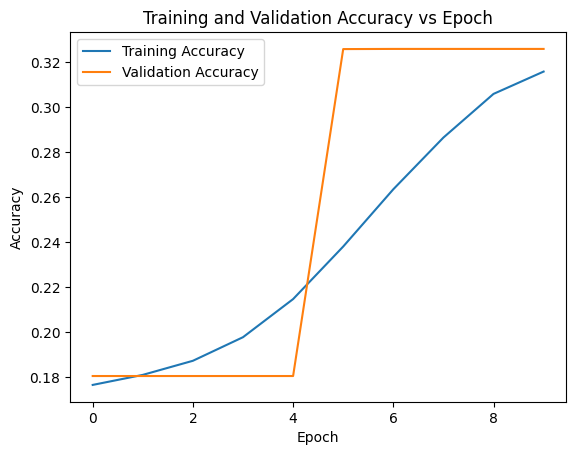

In [18]:
import matplotlib.pyplot as plt

# Plot the accuracy vs epoch graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Load the model
loaded_model = tf.keras.models.load_model("MODEL1.h5")

In [20]:
accuracy = model.evaluate(X_test_original, y_test_original)
print(f"Test Accuracy: {accuracy[1] * 100:.2f}%")

1/1 [==============================] - 1s 636ms/step - loss: 1.3641 - accuracy: 0.3258
Test Accuracy: 32.58%


In [21]:
## Given input sequence for prediction
input_sequence = ASM1153782v2

# One-hot encode the input sequence
X_input = np.array(one_hot_encode(input_sequence))
X_input = X_input[np.newaxis, :]
print(np.shape(X_input))


# Predict mutated sequence
predicted_sequence_encoded = model.predict(X_input)

# Decode the predicted sequence from one-hot encoding
base_encoding = {0: 'A', 1: 'T', 2: 'C', 3: 'G'}
predicted_sequence = ''.join([base_encoding[np.argmax(base)] for base in predicted_sequence_encoded[0]])

print(f"Original Sequence: {''.join([str(i) for i in input_sequence])}")
print(f"Predicted Mutated Sequence: {predicted_sequence}")

(1, 27317, 4)
1/1 [==============================] - 1s 816ms/step
Original Sequence: ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCG

In [22]:
model.save("MODEL1.h5")

/home/pranesh/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
